In [1]:
# cell 1
# =============================
# 数据准备:原子化拆解
# =============================
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
from dotenv import load_dotenv
import os

# 加载本地.env文件
load_dotenv()

# 从环境变量读取连接信息
USER = os.getenv("DB_USER")
PASSWORD = os.getenv("DB_PASS")
HOST = os.getenv("DB_HOST","localhost")
PORT = os.getenv("DB_PORT","5432")
DB = os.getenv("DB_NAME")

# 检查读取是否成功(调试用)
if not PASSWORD:
    print("警告:未找到数据库密码,请检查.env文件")
else:
    print("配置加载成功(具体信息已隐藏)")

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# 拉取全量原子数据
# df_items是商品量子化记录表
df_items = pd.read_sql("SELECT * FROM analysis.analysis_items_atomic", engine)
print(f"✅ 原子化数据准备完成。行数: {len(df_items)} (比订单数多，因为包含了 Mixed Basket)")
df_items.head()

配置加载成功(具体信息已隐藏)
✅ 原子化数据准备完成。行数: 110189 (比订单数多，因为包含了 Mixed Basket)


,order_id,order_item_id,product_id,seller_id,price,category,review_score,delay_days,is_late
0,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,pet_shop,4,-2.0,0
1,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,furniture_decor,5,-13.0,0
2,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,garden_tools,5,-15.0,0
3,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,21.90,housewares,4,-14.0,0
4,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,19.90,telephony,4,-16.0,0


In [2]:
# cell 2
# ========================================
# 寻找"钩子品类"及数据初步验证 (基于 Item 粒度)
# ========================================
# 钩子:"把用户领进门且留住"的商品,不要求用户第二次必须买同款
# 尤其在Olist这种耐用品为主的平台,"要求同款"会导致样本量归零

# 1. 数据准备
df_rfm = pd.read_sql("SELECT * FROM analysis.analysis_user_rfm", engine)
df_obt = pd.read_sql("SELECT * FROM analysis.analysis_orders_obt", engine)

# 2. 提取复购用户
repurchase_user_ids = df_rfm[df_rfm["frequency"] > 1]["user_id"]
print(f"复购用户总数: {len(repurchase_user_ids)}")

# 3. 寻找复购用户的"第一次下单"
# 3.1 寻找每个用户的首单id
first_orders_map = df_obt.sort_values("purchase_ts").groupby("user_id")["order_id"].first()

# 3.2 筛选出"复购用户"的首单order_id
repurchase_first_order_ids = first_orders_map[first_orders_map.index.isin(repurchase_user_ids)]

# 4. 提取首单购买品类信息
# 所有用户首单购买品类信息
items_pool = df_items

# 复购用户首单购买品类信息
hook_items_pool = df_items[df_items["order_id"].isin(repurchase_first_order_ids)]

# 5. 统计"钩子"
# 统计所有品类出现次数
item_counts = items_pool["category"].value_counts()

# 统计品类出现次数
hook_counts = hook_items_pool["category"].value_counts()

print('\n ["钩子品类"验证结果]')
print(f"复购用户首单包含的品类行数: {len(hook_items_pool)}")
#print("Top 10 潜在钩子品类 (按从高到低排序):")
display(
    hook_counts
    .head(10)
)

# 6.根据数据进行决策
# 只有当Top品类的样本量足够大(比如>30),我们才能进行关于"钩子品类"的进一步判断分析
top_1_count = hook_counts.iloc[0] if not hook_counts.empty else 0

if top_1_count < 30:
    print(f"\n 样本严重不足! Top 1 品类 ({hook_counts.index[0]}) 仅在 {top_1_count} 个复购用户的首单中出现")
    print("结论: 试图从品类维度寻找规律存在巨大的'随机性风险',建议放弃品类分析，转向供给侧(卖家)分析。")
else:
    print(f"\n 初步验证结论:头部样本尚可")

复购用户总数: 2801

 ["钩子品类"验证结果]
复购用户首单包含的品类行数: 3416


category
bed_bath_table              498
furniture_decor             393
sports_leisure              303
health_beauty               247
computers_accessories       235
housewares                  188
garden_tools                133
watches_gifts               130
telephony                   114
fashion_bags_accessories    113
Name: count, dtype: int64


 初步验证结论:头部样本尚可


总平均首单复购转化率: 3.11%
Top 10 高效钩子品类 (按复购率排序):


,retained_users,acquisition_users,retention_rate
category,,,
home_appliances,59,754,7.82%
fashion_bags_accessories,113,1985,5.69%
furniture_decor,393,8160,4.82%
bed_bath_table,498,10953,4.55%
sports_leisure,303,8430,3.59%
garden_tools,133,4268,3.12%
computers_accessories,235,7643,3.07%
pet_shop,58,1924,3.01%
home_construction,17,596,2.85%


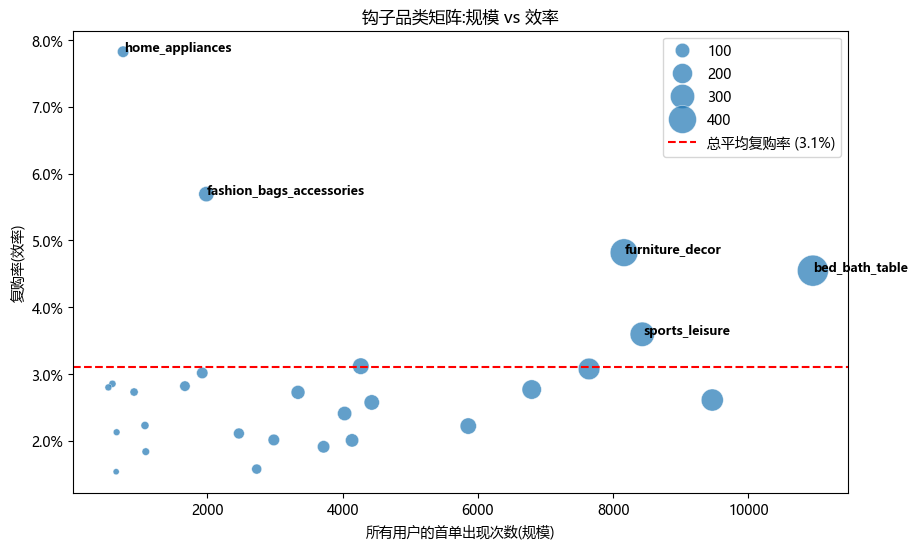

In [3]:
# cell 3
# ==========================================
# 进阶验证: 计算"相对复购率" 
# ==========================================
# 逻辑:进一步通过"相对复购效率"来筛选出"钩子品类"

import matplotlib as mpl
from matplotlib.ticker import PercentFormatter

# 保证中文正常显示
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Noto Sans CJK SC", "Source Han Sans SC"]

# 1. 数据准备
# items_pool:所有用户的首单品类信息
# item_counts:所有用户的首单品类出现次数
# hook_items_pool:复购用户的首单品类信息
# hook_counts:复购用户的首单品类出现次数
acquisition_counts = item_counts.rename("acquisition_users")
retention_counts = hook_counts.rename("retained_users")

# 2. 计算转换率
# concat(...,axis)表示把两张有相同"index"的表按列拼在一起
# 储存每个品类(index)对应的"所有用户首单出现次数","复购用户的首单出现次数"
hook_analysis = (
    pd.concat([acquisition_counts,retention_counts],axis=1)
    .fillna(0)
    .astype({"acquisition_users": "int64", "retained_users": "int64"})
)

# 计算每个品类对应的"复购率"(= "复购用户的首单出现次数" / "所有用户首单出现次数")
hook_analysis["retention_rate"] = hook_analysis["retained_users"].astype("float64") / hook_analysis["acquisition_users"]

# 3. 过滤小样本(只看总获客数 > 500的品类,保证稳健性)
valid_hooks = hook_analysis[hook_analysis["acquisition_users"] > 500].sort_values("retention_rate", ascending=False)

# 4. 计算总平均复购率(作为基准线)
# 总平均复购率(所有品类) = 复购用户数 / 总获客数
global_avg = hook_analysis["retained_users"].sum() / hook_analysis["acquisition_users"].sum()

print(f"总平均首单复购转化率: {global_avg:.2%}")
print("Top 10 高效钩子品类 (按复购率排序):")
display(
    valid_hooks[["retained_users","acquisition_users","retention_rate"]]
    .head(10)
    .style.format({"retention_rate":"{:.2%}"})
)

# 5. 可视化:"规模 vs 效率"矩阵
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=valid_hooks,
    x="acquisition_users",
    y="retention_rate", 
    size="retained_users",
    sizes=(20, 500), 
    alpha=0.7
)

# 画基准线
plt.axhline(global_avg, color="red", linestyle="--", label=f'总平均复购率 ({global_avg:.1%})')
plt.title('钩子品类矩阵:规模 vs 效率')
plt.xlabel('所有用户的首单出现次数(规模)')
plt.ylabel('复购率(效率)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()

# 标出 Top 5
for i in range(5):
    row = valid_hooks.iloc[i]
    plt.text(
        row["acquisition_users"]+10, 
        row["retention_rate"], 
        valid_hooks.index[i],
        weight="bold", 
        fontsize=9
    )

plt.show()


[供给侧分析数据]
总活跃卖家(订单数大于30): 611
需要处理的恶劣卖家数: 31 (占比 5.1%)
恶劣卖家贡献的违约单比例: 11.3% (帕累托效应)


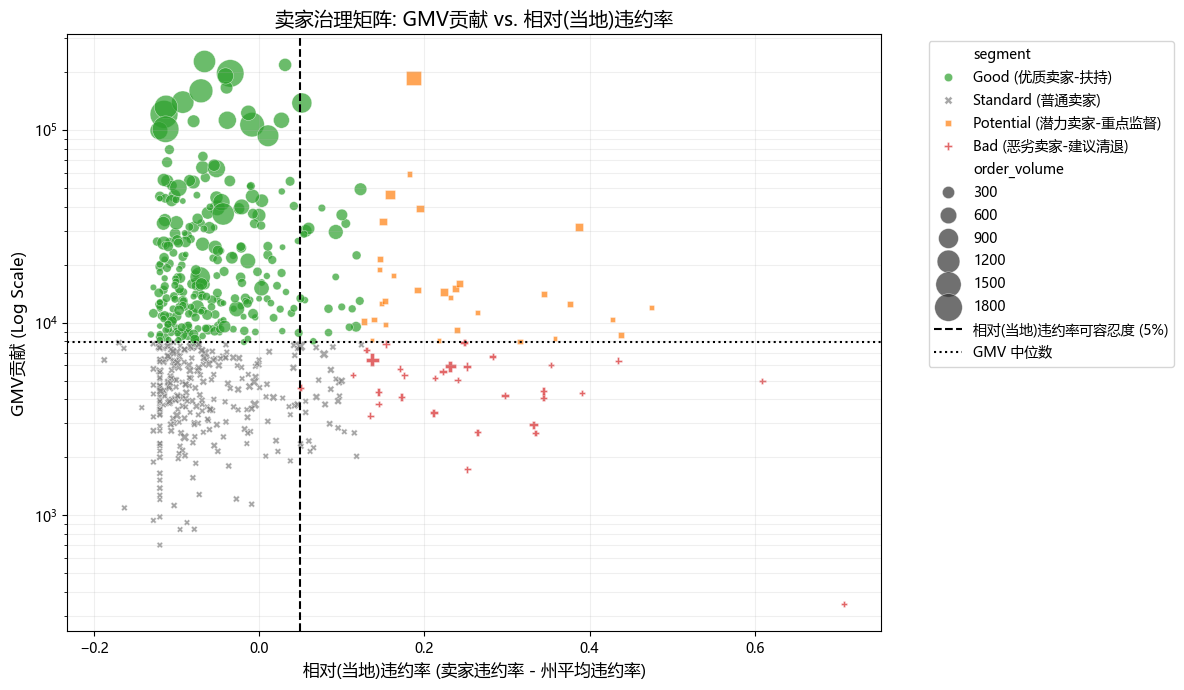

,seller_id,price,sla_breach_rate
segment,,,
Good (优质卖家-扶持),275,"$7,997,972",6.6%
Standard (普通卖家),275,"$1,234,820",5.9%
Potential (潜力卖家-重点监督),30,"$694,280",35.4%
Bad (恶劣卖家-建议清退),31,"$148,531",37.7%


In [4]:
# Cell 4
# ==========================================
# 四. 供给侧全景诊断:归因、分层与治理
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------------------
# 1. 数据准备与特征工程(归因解耦)
# ------------------------------------------
# 目标: 获取shipping_limit_date(平台规定的商家最迟发货时间--SLA截止时间)
# 注意: 1.同一个订单里面不同商品的卖家不同,同一订单的不同商品最迟发货时间也可能不同
#      2.同一个订单所有商品的实际发货时间是一致的
# Olist.olist_order_items_dataset表记录了每个订单的SLA截止时间
# analysis.analysis_orders_obt表记录了每个订单的实际发货时间

# 读取原始商品详细数据(包括SLA截止时间)
df_raw_items = pd.read_sql(
"""
    SELECT 
        order_id, 
        order_item_id, 
        seller_id, 
        shipping_limit_date::TIMESTAMP AS shipping_limit_date, 
        price::numeric AS price 
    FROM Olist.olist_order_items_dataset
""", engine)

# 读取 OBT 数据 (包含实际发货时间)
df_obt_delivery = pd.read_sql(
"""
    SELECT 
        order_id, 
        carrier_ts AS carrier_date
    FROM analysis.analysis_orders_obt
""", engine)

# 关联数据
df_seller_audit = df_raw_items.merge(df_obt_delivery, on="order_id", how="inner")

# 转换时间类型
df_seller_audit["shipping_limit_date"] = pd.to_datetime(df_seller_audit["shipping_limit_date"])
df_seller_audit["carrier_date"] = pd.to_datetime(df_seller_audit["carrier_date"])

# 核心指标: SLA违约标记(1=违约, 0=守约)
# 逻辑: 卖家发货时间 > 最迟发货时间 = 卖家全责
df_seller_audit["is_sla_breach"] = (df_seller_audit["carrier_date"] > df_seller_audit["shipping_limit_date"]).astype(int)

# ------------------------------------------
# 2. 卖家信息聚合(包含地理信息)
# ------------------------------------------
# 读取卖家地理信息
df_sellers_geo = pd.read_sql("SELECT seller_id, seller_state FROM Olist.olist_sellers_dataset", engine)

# 聚合计算
seller_stats = df_seller_audit.groupby("seller_id").agg({
    
    # 计算卖家参与的不同订单数量
    'order_id': 'nunique',          # 订单量
    'price': 'sum',                 # GMV
    
    # 因为数值为0或1,直接取平均值可以得到违约率
    'is_sla_breach': 'mean'         # 违约率
}).rename(columns={'order_id': 'order_volume', 'is_sla_breach': 'sla_breach_rate'})

# 添加地理信息
seller_stats = seller_stats.merge(df_sellers_geo, on="seller_id", how="left")

# ------------------------------------------
# 3. 相对绩效计算(公平性校准)
# ------------------------------------------
# 计算各州的"平均违约率"作为基准 (用来排除偏远地区揽收难的客观地理因素)
state_benchmark = seller_stats.groupby("seller_state")["sla_breach_rate"].mean().rename("state_avg_breach_rate")

# 添加对应州基准
seller_final = seller_stats.merge(state_benchmark, on='seller_state', how='left')

# 计算Performance Gap(相对违约率 = 卖家违约率 - 当地平均违约率)
# Gap > 0: 比基准慢 (卖家问题)
seller_final["performance_gap"] = seller_final["sla_breach_rate"] - seller_final["state_avg_breach_rate"]

# 过滤长尾 (只看订单量 > 30 的卖家)
main_sellers = seller_final[seller_final["order_volume"] > 30].copy()

# ------------------------------------------
# 4. 策略分层(向量化实现)
# ------------------------------------------
# 计算卖家的总GMV中值,作为划分基线
gmv_threshold = main_sellers["price"].median()

# 设定容忍度:比当地平均差 5%
gap_threshold = 0.05

# 定义条件
cond_lazy = main_sellers["performance_gap"] > main_sellers["state_avg_breach_rate"] * (1 + gap_threshold)
cond_rich = main_sellers["price"] > gmv_threshold

# 定义标签
conditions = [
    (cond_lazy & ~cond_rich),  # 发货慢且贡献小
    (cond_lazy & cond_rich),   # 发货慢且贡献大
    (~cond_lazy & cond_rich),  # 发货快且贡献大
    (~cond_lazy & ~cond_rich)  # 发货快且贡献小 (长尾)
]
choices = [
    'Bad (恶劣卖家-建议清退)', 
    'Potential (潜力卖家-重点监督)', 
    'Good (优质卖家-扶持)', 
    'Standard (普通卖家)'
]

main_sellers["segment"] = np.select(conditions, choices, default="Standard")

# ------------------------------------------
# 5. 帕累托集中度分析
# ------------------------------------------
# 目标: 计算劣质卖家造成的危害集中度

# 提取"劣质卖家"
bad_sellers = main_sellers[main_sellers["segment"].isin(['Bad (恶劣卖家-建议清退)'])]

# "劣质卖家"的违约单量 = "劣质卖家"订单数 × "劣质卖家"总平均违约率
bad_orders = bad_sellers["order_volume"].sum() * bad_sellers["sla_breach_rate"].mean()

# 总期望违约单量 = 每个卖家的违约单量再加和
# 每个卖家的违约单量 = 订单数 × 总平均违约率
total_breach_orders = (main_sellers["order_volume"] * main_sellers["sla_breach_rate"]).sum()

# "劣质卖家"违约单占比 = "劣质卖家"违约单量 / 总违约单量
concentration_ratio = bad_orders / total_breach_orders if total_breach_orders > 0 else 0

print(f"\n[供给侧分析数据]")
print(f"总活跃卖家(订单数大于30): {len(main_sellers)}")
print(f"需要处理的恶劣卖家数: {len(bad_sellers)} (占比 {len(bad_sellers)/len(main_sellers):.1%})")
print(f"恶劣卖家贡献的违约单比例: {concentration_ratio:.1%} (帕累托效应)")

# ------------------------------------------
# Step 6: 数据可视化 (治理矩阵)
# ------------------------------------------
# 绘制散点图,对各类卖家分层可视化
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=main_sellers, 
    # x轴为相对(当地)违约率
    x="performance_gap", 
    # y轴为卖家贡献的总GMV
    y="price", 
    hue="segment", 
    style="segment",
    palette={'Bad (恶劣卖家-建议清退)': '#d62728', 'Potential (潜力卖家-重点监督)': '#ff7f0e', 
             'Good (优质卖家-扶持)': '#2ca02c', 'Standard (普通卖家)': 'grey'},
    size="order_volume", 
    sizes=(20, 400), 
    alpha=0.7
)

# 辅助线
plt.axvline(gap_threshold, color='black', linestyle='--', label=f'相对(当地)违约率可容忍度 ({gap_threshold:.0%})')
plt.axhline(gmv_threshold, color='black', linestyle=':', label='GMV 中位数')

# 标注
plt.title('卖家治理矩阵: GMV贡献 vs. 相对(当地)违约率', fontsize=14)
plt.xlabel('相对(当地)违约率 (卖家违约率 - 州平均违约率)', fontsize=12)
plt.ylabel('GMV贡献 (Log Scale)', fontsize=12)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

# 输出分层统计表
display(main_sellers.groupby("segment").agg({
    'seller_id': 'count',
    'price': 'sum',
    'sla_breach_rate': 'mean'
}).sort_values('price', ascending=False).style.format({
    'price': '${:,.0f}', 
    'sla_breach_rate': '{:.1%}'
}))



[商业价值核算]
风险敞口(劣质卖家涉及的GMV): 148,530.59
  - 这部分GMV由劣质卖家经手，平均(发货)违约率高达 37.7%
  - 若不治理，这部分营收不仅可能变成低评分订单，甚至可能产生退款,永久伤害用户留存


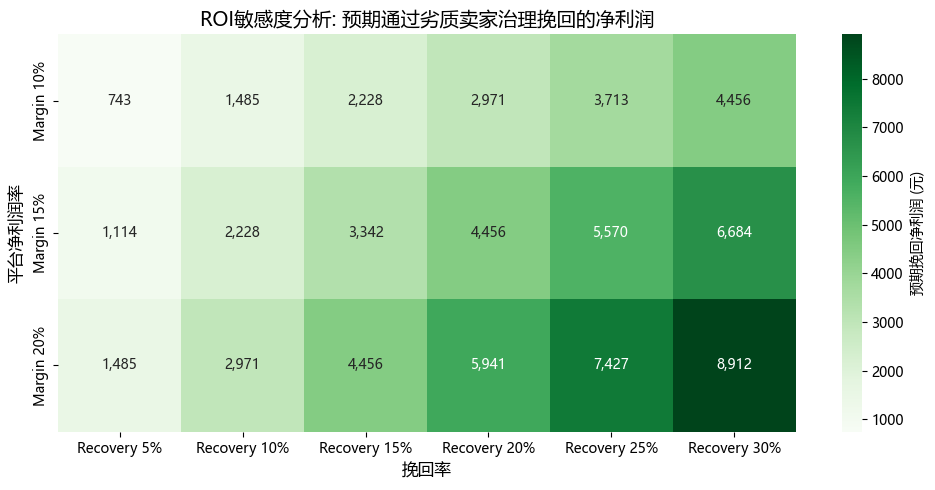


结论: 即使按保守估计( 10% 挽回率, 15% 利润率)
治理劣质卖家预计能直接为平台挽回净利润: 2,228 元
(这仅是直接财务收益，尚未计算用户LTV提升等带来的长期价值)


In [6]:
# Cell 5
# ==========================================
# 五. 商业闭环:风险价值(VaR)与敏感性分析
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# ----------------------------------------
# 1. 计算风险敞口 (Value at Risk)
# ----------------------------------------
# 定义: 由"劣质卖家"经手、且发生发货违约(SLA Breach)的订单金额
# 逻辑: 这部分钱是平台面临退款风险或导致用户流失的高危资金

# 重新筛选出劣质卖家
bad_sellers_list = main_sellers[main_sellers["segment"] == 'Bad (恶劣卖家-建议清退)']["seller_id"]

# 计算劣质卖家涉及的总GMV
# 这里计算total price,代表"劣质卖家能影响的生意规模"
gmv_at_risk = main_sellers[main_sellers["segment"] == 'Bad (恶劣卖家-建议清退)']["price"].sum()

# 计算劣质卖家的违约单占比 (SLA Breach Rate)
bad_breach_rate = main_sellers[main_sellers["segment"] == 'Bad (恶劣卖家-建议清退)']["sla_breach_rate"].mean()

print(f"\n[商业价值核算]")
print(f"风险敞口(劣质卖家涉及的GMV): {gmv_at_risk:,.2f}")
print(f"  - 这部分GMV由劣质卖家经手，平均(发货)违约率高达 {bad_breach_rate:.1%}")
print(f"  - 若不治理，这部分营收不仅可能变成低评分订单，甚至可能产生退款,永久伤害用户留存")

# --------------------------------------------------------
# 2. 敏感性分析
# --------------------------------------------------------
# 逻辑: 不预测单一数值，而是计算在不同"治理成功率"下的收益矩阵
# 探究: 如果将这部分订单转移给优质卖家(或通过治理让劣质卖家变好)，能挽回多少损失？

# 设定情景: 挽回比例 (Recovery Rate) 从 5% 到 30%
recovery_rates = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
# 设定情景: 净利润率 (Net Margin) - 保守假设平台佣金+广告费约为 15%
# 设定多个利润率方便可视化对比
margin_rates = [0.10, 0.15, 0.20] 

# 构建"不同挽回比例、净利润率组合"的挽回净利润矩阵数据
sensitivity_data = []
for margin in margin_rates:
    # 初始化
    row = []
    for rate in recovery_rates:
        # 挽回的净利润 = 风险GMV * 挽回比例 * 净利润率
        saved_profit = gmv_at_risk * rate * margin
        row.append(saved_profit)
    sensitivity_data.append(row)

# 矩阵数据转为DataFrame用于绘图
df_sensitivity = pd.DataFrame(
    sensitivity_data, 
    index=[f"Margin {m:.0%}" for m in margin_rates], 
    columns=[f"Recovery {r:.0%}" for r in recovery_rates]
)

# --------------------------------------
# 3. 可视化:收益热力图
# --------------------------------------
plt.figure(figsize=(10, 5))
sns.heatmap(df_sensitivity, annot=True, fmt=",.0f", cmap="Greens", cbar_kws={'label': '预期挽回净利润 (元)'})

plt.title('ROI敏感度分析: 预期通过劣质卖家治理挽回的净利润', fontsize=14)
plt.xlabel('挽回率', fontsize=12)
plt.ylabel('平台净利润率', fontsize=12)
plt.tight_layout()
plt.show()


print("\n结论: 即使按保守估计( 10% 挽回率, 15% 利润率)")
print(f"治理劣质卖家预计能直接为平台挽回净利润: {gmv_at_risk * 0.1 * 0.15:,.0f} 元")
print("(这仅是直接财务收益，尚未计算用户LTV提升等带来的长期价值)")